# Exploring Data:
 Now we have to explore our new resampled prepared data to see its features that can help us in the modeling procedure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Reading data
full_grid = pd.read_csv("resampled_full_grid.csv", parse_dates = ["time"])

In [3]:
full_grid.head()

,time,grid_square,internet_cdr
0,2013-11-01 00:00:00,1,11.028366
1,2013-11-01 00:10:00,1,11.100963
2,2013-11-01 00:20:00,1,10.892771
3,2013-11-01 00:30:00,1,8.622425
4,2013-11-01 00:40:00,1,8.009927


In [4]:
full_grid.shape

(89280000, 3)

In [5]:
full_grid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89280000 entries, 0 to 89279999
Data columns (total 3 columns):
 #   Column        Dtype         
---  ------        -----         
 0   time          datetime64[ns]
 1   grid_square   int64         
 2   internet_cdr  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.0 GB


### 1. Internet traffic devation and distribuion:

In [7]:
full_grid["internet_cdr"].describe()

count    8.912746e+07
mean     6.211785e+01
std      1.210315e+02
min      0.000000e+00
25%      1.095038e+01
50%      2.683564e+01
75%      6.236089e+01
max      7.936265e+03
Name: internet_cdr, dtype: float64

We Can see the huge deviation that found in the traffic as we expected due to difference in load in different areas, but also that can a difference between busy and zy hours for the same grid sqaure.

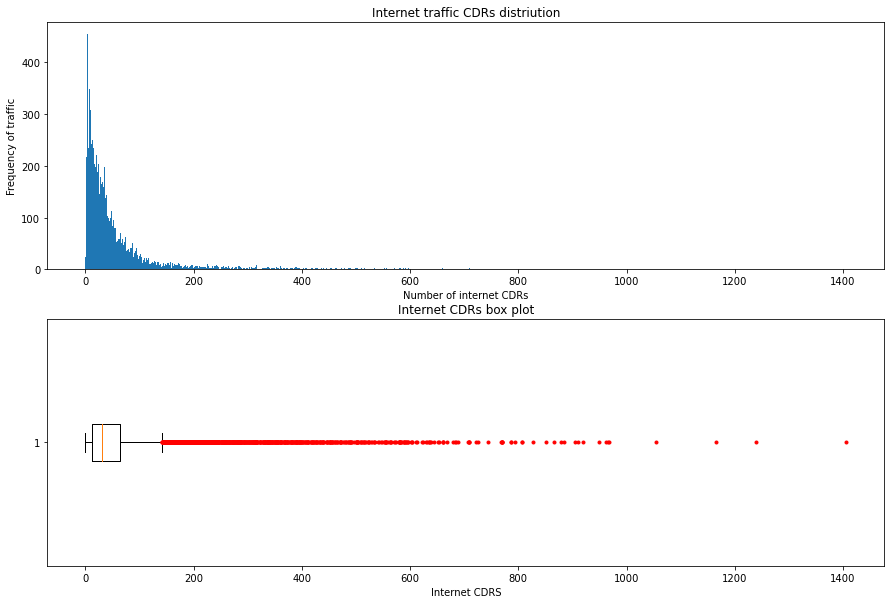

In [23]:
full_grid1 = full_grid.groupby("grid_square")["internet_cdr"].mean()

fig, ax = plt.subplots(2,1,figsize = (15, 10))
ax[0].hist(full_grid1, bins = 1000)
ax[0].set_xlabel("Number of internet CDRs")
ax[0].set_ylabel("Frequency of traffic")
ax[0].set_title("Internet traffic CDRs distriution")
ax[1].boxplot(full_grid1, vert = False, sym = "r.")
ax[1].set_title("Internet CDRs box plot")
ax[1].set_xlabel("Internet CDRS")
plt.show()

In [21]:
type(full_grid1)

pandas.core.series.Series

So Most of grid sqaures exhibits a mean internet usage between 0 and 200 cdrs, which is the dominant rate so in most cases the network can handle the dominant rate well, but for those grids that exhibits a huge traffic it's expected to be the in the active region which can have interest features and also we can see the traffic very well, and can be the useful for our analysis, and reasonable to analyze the highly loaded areas.

### Number Of time stamps on the data:

As Our Understanding says, it's expected to have 62(days)*144(time stamps) = 8928 Unique timestamps in the data and we are going to vlidate that.

In [8]:
#Number of time stamps:
len(full_grid["time"].unique())

8928

### Null Values of the data:

In [9]:
# Null Values
full_grid.isna().sum()

time                 0
grid_square          0
internet_cdr    152539
dtype: int64

We Have 152539 Null values o the data, the sources of the null values here is divided into two sources, our resampling process and natual data generating process, and the two sources means that there are missed records in some areas.. 

### Number of Grids:

We expect to have 10000 grids as the Milan city grid was dvided into 100*100 grid.

In [24]:
# Number of grids
full_grid = full_grid.groupby("grid_square")
grids = list(full_grid.groups.keys())
num_grids = len(grids) 
print("We have {} grid sqaures in Milan City".format(num_grids))

We have 10000 grid sqaures in Milan City


## Exploring the data:

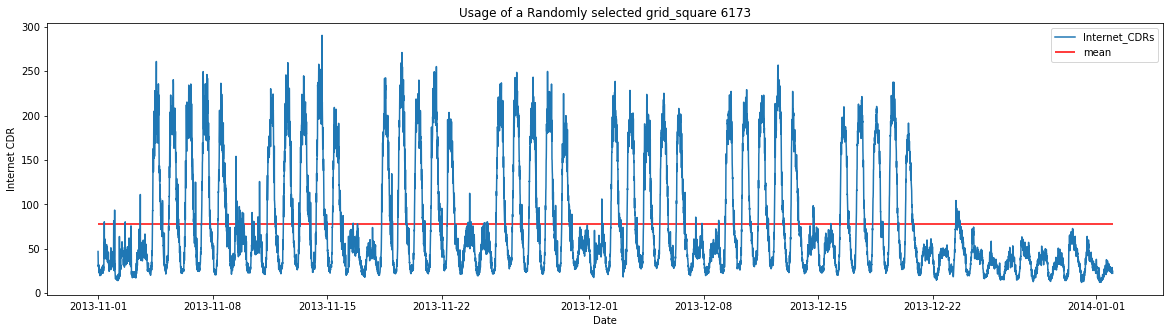

In [39]:
# pick Random Square
random_grid = np.random.choice(grids)
g1 = full_grid.get_group(3083)

#Plot
fig, ax = plt.subplots(figsize = (20,5))
ax.set_title("Usage of a Randomly selected grid_square {}".format(random_grid))
ax.plot(g1["time"],g1["internet_cdr"], label = "Internet_CDRs");
ax.hlines(g1["internet_cdr"].mean(), g1.iloc[:1, 0], g1.iloc[-1:, 0], label = "mean", color = "r")
ax.set_xlabel("Date")
ax.set_ylabel("Internet CDR")
plt.legend()

Form this graph for the grid square 3083 we can see the obvious seasonality and also it has a mean usage arround 90 CDRs which is one form the dominant traffic in the data. 8061
The other thing that we can see here is that in the christmas days the data is almost biased or different from the rest of the data, and that may happe due to christmas and new year's holidays, which affect our traffic, and also can affect modeling by biasing the models' errors so that's harmful for the modeling process except that we have a yeatly data that contain a yearly information about the traffic, which is not our case.

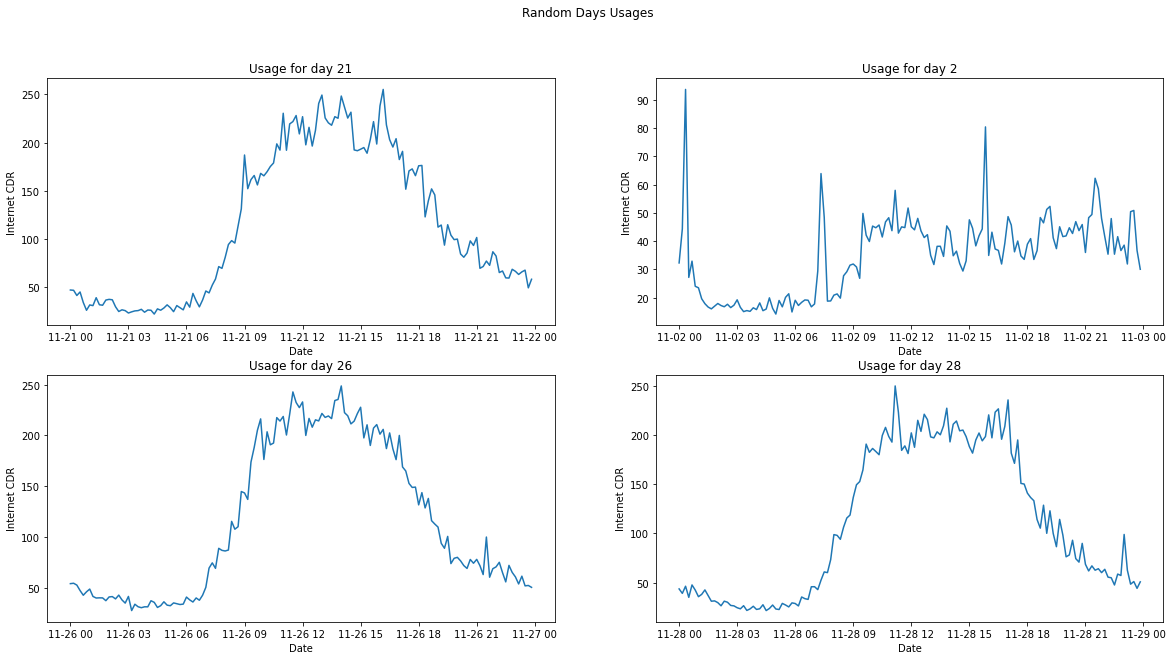

In [40]:
#Random Days
random_days = np.random.randint(1,30,4)

fig, axs = plt.subplots(2,2, figsize = (20,10))
fig.suptitle("Random Days Usages")
for i, day in enumerate(random_days):
    g2 = g1[g1["time"].dt.day == day][:144]
    axs[int(i/2),i%2].set_title("Usage for day {}".format(day))
    axs[int(i/2),i%2].plot(g2["time"], g2["internet_cdr"])
    axs[int(i/2),i%2].set_xlabel("Date")
    axs[int(i/2),i%2].set_ylabel("Internet CDR")


From this plots of Random days for the selected grid, we can see that in most days we have ordinary traffic, but also we have days that have lower traffic which indicates that the usage is dependant on the day so to investigate that we have to plot weekly usage to know more.

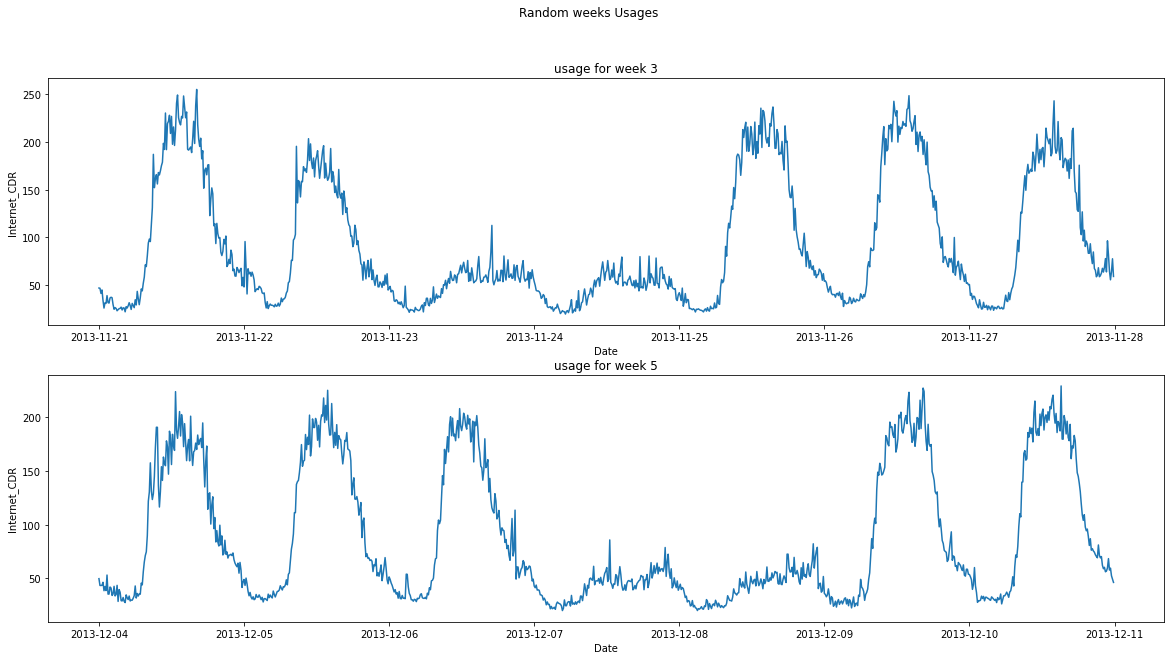

In [51]:
#Random Weeks:
weeks_starts = np.random.randint(1,55,2)

fig, axs = plt.subplots(2,1, figsize=(20,10))
fig.suptitle("Random weeks Usages")
for i, day in enumerate(weeks_starts):
    g3 = g1[day*144:day*144+1008]
    week_num = int(day/7)
    axs[i%2].set_title("usage for week {}".format(week_num+1))
    axs[i%2].plot(g3["time"], g3["internet_cdr"])
    axs[i%2].set_xlabel("Date")
    axs[i%2].set_ylabel("Internet_CDR")

From these different weeks we can see that the internet traffic CDRs is affected by the weekends which make sense because the in weekends there is no traffic comes from businesses, so we now know the main seasonality features on the data.

<BarContainer object of 1275 artists>

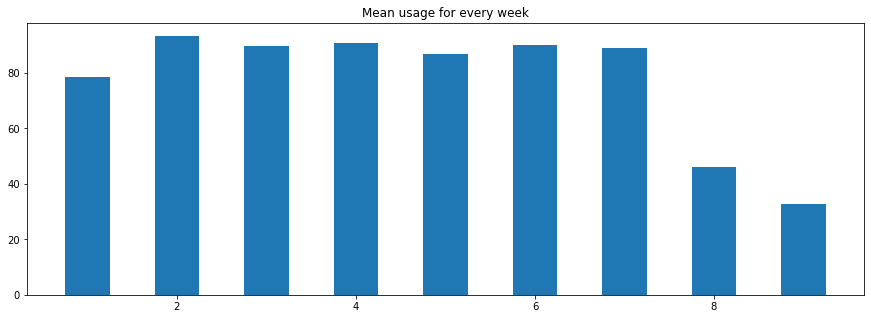

In [97]:
# Weeks Means:
num_weeks = int(len(g1) / 7)
weeks_means = {}
for week in range(num_weeks):
    g4 = g1[week*1008:(week+1)*1008]
    weeks_means[week+1] = g4["internet_cdr"].mean()

fig, ax = plt.subplots(figsize = (15,5))
ax.set_title("Mean usage for every week")
ax.bar(list(weeks_means.keys()), list(weeks_means.values()), width = 0.5)

As We expeted the last two weeks exhibits lower means of internet usage due to the christmas and new year's holidays.

## Grid Number and Mean usage Relationship.

As we saw in the histogram of intenet traffic there is a huge diversity in the internet CDRs exhibited from differnet cell, but is the position of the grid which is represented by its number affects the mean usage on this grid square ?

In [11]:
# Usage over grids
bin_size = int(num_grids/5)
bin_mean = []
bin_indeces = []

for i in range(5):
    bin_indeces.append((i+1)*(bin_size))
means_grid_usage = []
for grid in grids:
    mean_int_usage = full_grid.get_group(grid)[["internet_cdr"]].mean()[0]
    means_grid_usage.append(mean_int_usage)
for i, bin_ in enumerate(bin_indeces):
    bin_mean.append(np.mean(means_grid_usage[i*bin_size:(i*bin_size)+bin_size]))

In [12]:
len(means_grid_usage)

10000

Text(0.5, 1.0, 'Mean internet Usage for all grids')

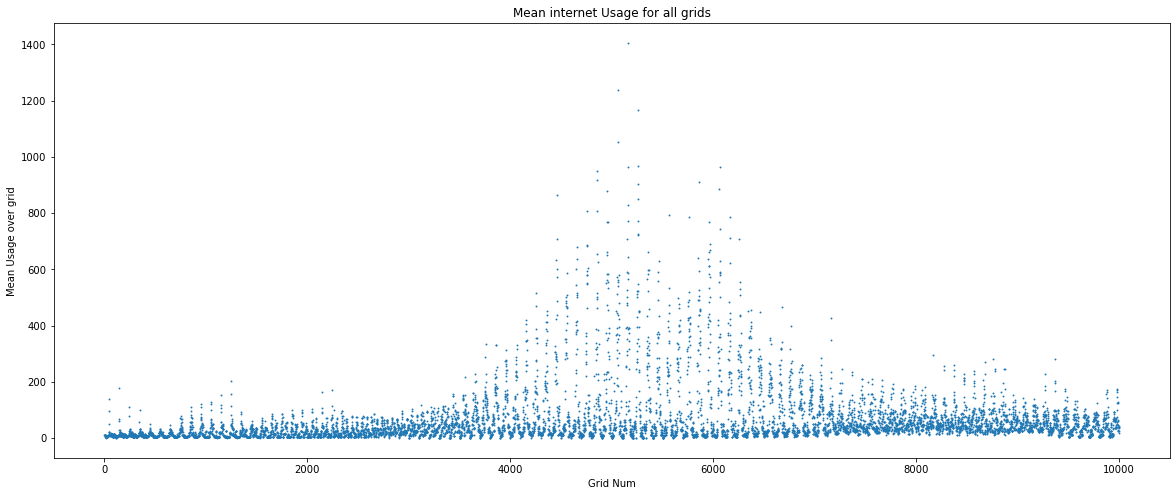

In [14]:
plt.figure(figsize = (20,8))
plt.scatter(x = grids, y = means_grid_usage, s = 0.8);
plt.xlabel('Grid Num')
plt.ylabel('Mean Usage over grid')
plt.title('Mean internet Usage for all grids')

#### We can see that the usage in the middle grids is more than the there grids 

In [101]:
bin_indeces

[2000, 4000, 6000, 8000, 10000]

In [102]:
bin_mean

[16.920469692345115,
 40.21956055348202,
 119.95695210443263,
 78.28422341685133,
 54.92163815760333]

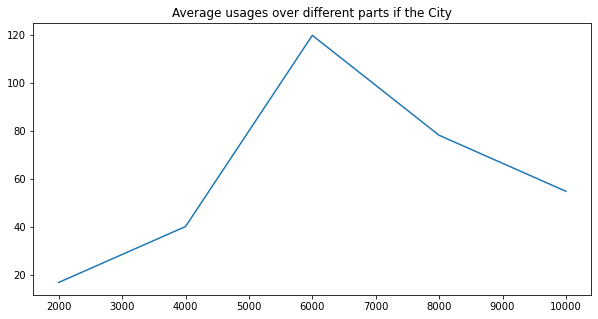

In [103]:
# fig, ax = plt.subplots(figsize=(10,5))
plt.figure(figsize  = (10,5))
plt.title("Average usages over different parts if the City")
plt.plot(list(bin_indeces), list(bin_mean))

From the previuos Scatter plot and line plot that represnted the mean usage accross different grids, and as an abservation we see that the grids whose numbers between 4000 and 6000 exhibits the largest mean intenet traffic usages.

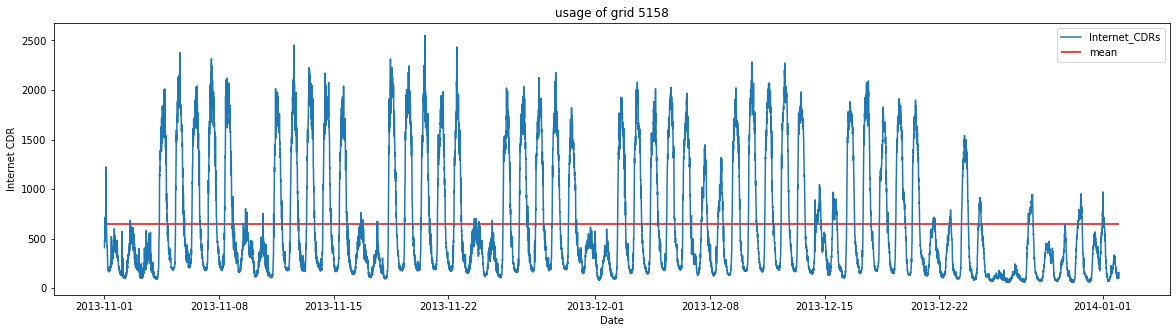

In [53]:
#Getting a grid square that its number between 4000 and 6000
g1 = full_grid.get_group(5158)

#Plot
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(g1["time"],g1["internet_cdr"], label = "Internet_CDRs");
ax.hlines(g1["internet_cdr"].mean(), g1.iloc[:1, 0], g1.iloc[-1:, 0], label = "mean", color = "r")
ax.set_xlabel("Date")
ax.set_ylabel("Internet CDR")
ax.set_title("usage of grid 5158")
plt.legend()

As Expected the internet usage is more than the the grid 3083, and exhibits a mea usage of 600 CDRs and maximum usage arround 2500.

In [55]:
#Load the numpy version of the data
data1 = np.load("full_data_imputed.npy", allow_pickle = True)

In [20]:
#Stat of day 25 
start_25 = 56*144
end_25 = start_25+144

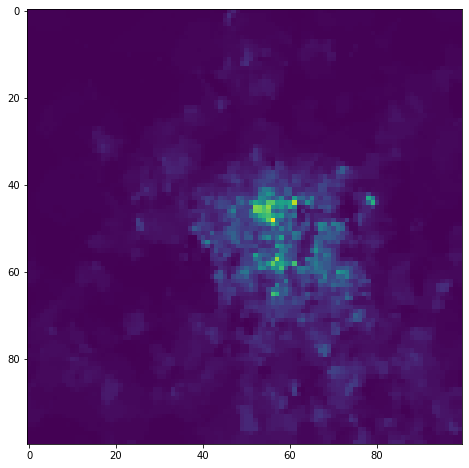

In [39]:
# get Random Snapshots of that day
import time
from matplotlib import animation
snapshot_num = range(start_25, end_25)

fig = plt.figure(figsize = (8,8))
snap25 = data1[start_25, :, :]
# def init(snap):
#     plt.imshow(snap, interpolation='nearest')
def animate(i):
    global data1
    snap = data1[i, :, :]
    plt.imshow(snap, interpolation='nearest')
    
anim = animation.FuncAnimation(fig, animate, frames = 144,  repeat = False, interval = 500)

In [65]:
#geting the mean usage accross all grids individually and all time stamps and reshaping it to be a 2D numpy array:
npara = np.reshape(np.array(means_grid_usage), (100,100))

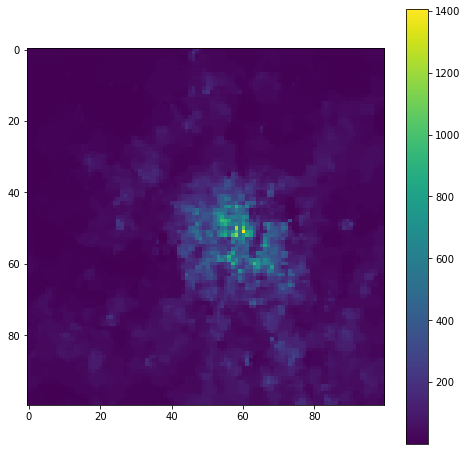

In [66]:
# Plotting the mean usages:
plt.figure(figsize = (8,8))
plt.imshow(npara, interpolation='nearest')
plt.colorbar()
plt.show()

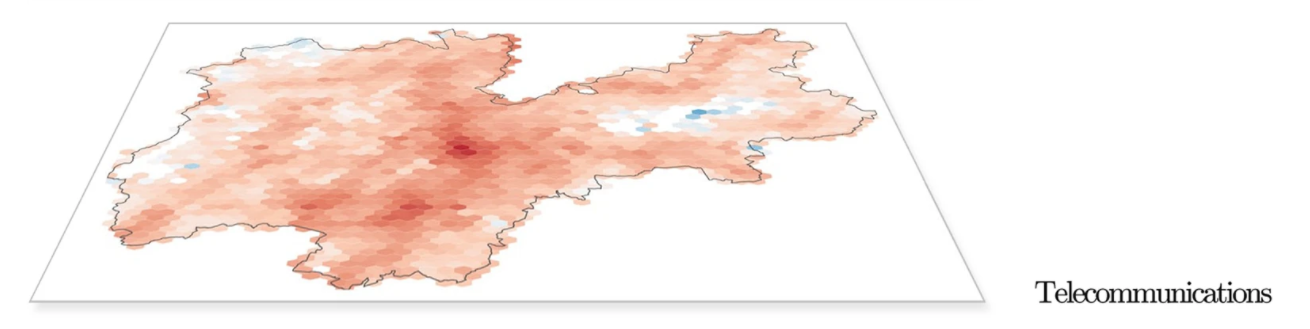

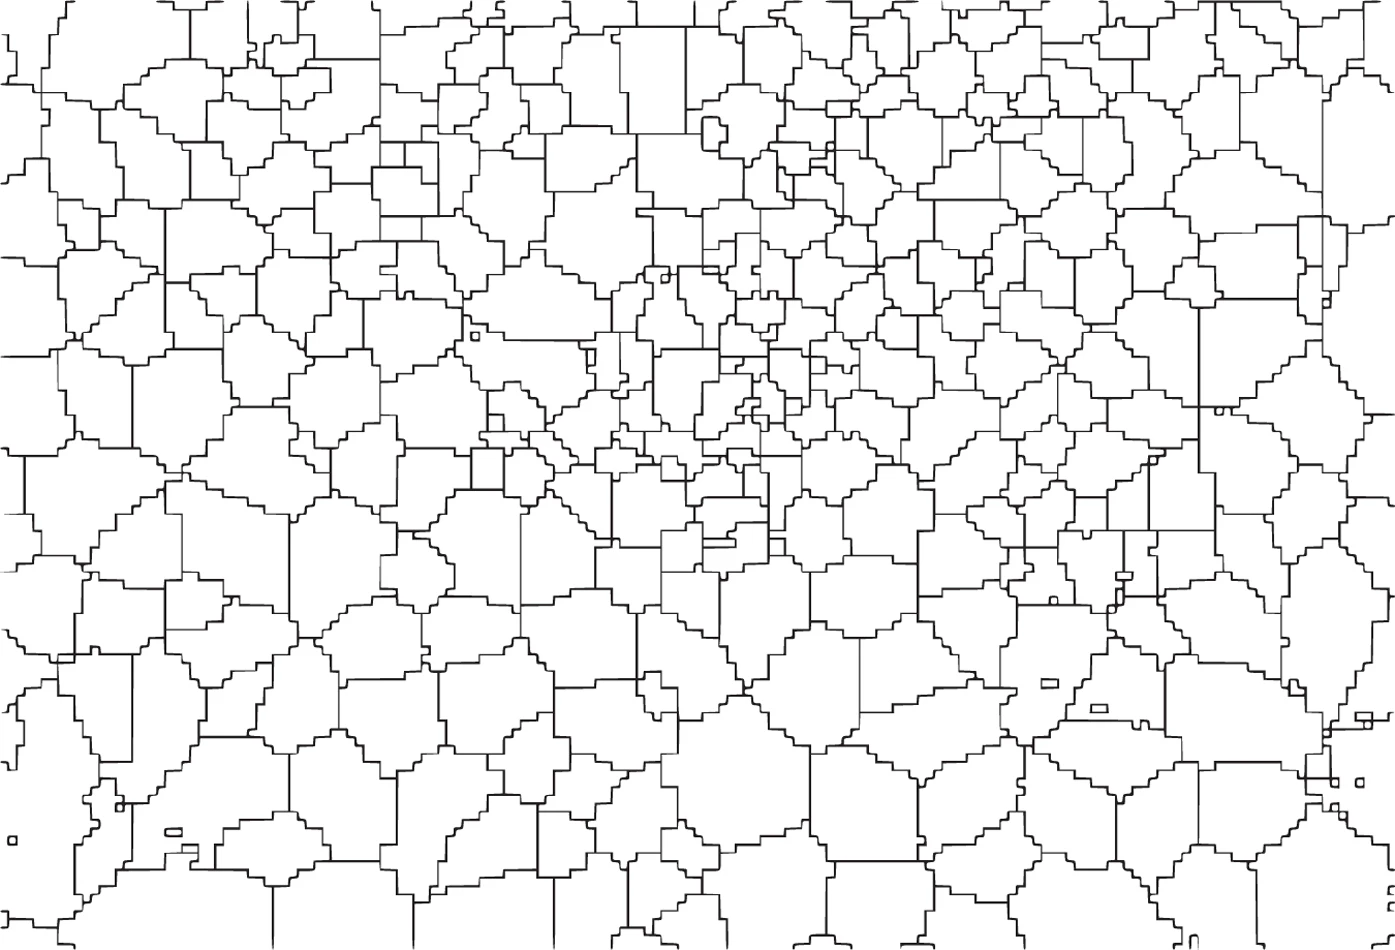

From the above graphs, as a result of the dense area in the middle of the city whis is represented by the grids with numbers ranging from 4000 to 6000, the internet usage there was the largest on the city of milan, and these grids represents our area of interest.

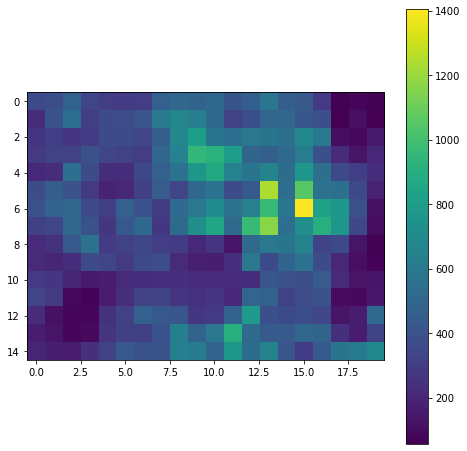

In [67]:
# Getting sub grids form the middle of the graph
plt.figure(figsize = (8,8))
plt.imshow(npara[45:60,45:65], interpolation='nearest')
plt.colorbar()
plt.show()

But these indeces are no the actual one o our grid because this is the indeces of the numby array not in our acutal data, so we need to know the actual griid numbers.

In [68]:
#calculate number of grids:
rows_  = np.arange(45,61,1)
size_ = np.array([100]*len(rows_))
actual_grid_numbers = size_*rows_ 
cols_ =(45,65) 
actual_indeces = {}
for r in actual_grid_numbers:
    actual_indeces[r+cols_[0]] = r+cols_[1]

In [69]:
actual_indeces

{4545: 4565,
 4645: 4665,
 4745: 4765,
 4845: 4865,
 4945: 4965,
 5045: 5065,
 5145: 5165,
 5245: 5265,
 5345: 5365,
 5445: 5465,
 5545: 5565,
 5645: 5665,
 5745: 5765,
 5845: 5865,
 5945: 5965,
 6045: 6065}

These are the ranges of grid numbers that we are searching for, but we want the individual indeces from this data.

In [70]:
indeces_indv = []
starts = list(actual_indeces.keys())
ends = list(actual_indeces.values())
for i in range(len(starts)):
    range_ = list(np.arange(starts[i], ends[i], 1))
    indeces_indv.append(range_)

In [71]:
indeces_indv = np.array(indeces_indv).flatten()
print(len(indeces_indv))

320


In [72]:
indeces_indv

array([4545, 4546, 4547, 4548, 4549, 4550, 4551, 4552, 4553, 4554, 4555,
       4556, 4557, 4558, 4559, 4560, 4561, 4562, 4563, 4564, 4645, 4646,
       4647, 4648, 4649, 4650, 4651, 4652, 4653, 4654, 4655, 4656, 4657,
       4658, 4659, 4660, 4661, 4662, 4663, 4664, 4745, 4746, 4747, 4748,
       4749, 4750, 4751, 4752, 4753, 4754, 4755, 4756, 4757, 4758, 4759,
       4760, 4761, 4762, 4763, 4764, 4845, 4846, 4847, 4848, 4849, 4850,
       4851, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859, 4860, 4861,
       4862, 4863, 4864, 4945, 4946, 4947, 4948, 4949, 4950, 4951, 4952,
       4953, 4954, 4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962, 4963,
       4964, 5045, 5046, 5047, 5048, 5049, 5050, 5051, 5052, 5053, 5054,
       5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5063, 5064, 5145,
       5146, 5147, 5148, 5149, 5150, 5151, 5152, 5153, 5154, 5155, 5156,
       5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5245, 5246, 5247,
       5248, 5249, 5250, 5251, 5252, 5253, 5254, 52

Now we get the grids that we want, let's check them.

### Check the chosen subset:

In [73]:
#Getting the mean usage data for the chosen grids:
grid_menas_sub = []
for g in indeces_indv:
    grid_menas_sub.append(means_grid_usage[g])
    print("inde {} added".format(g))

inde 4545 added
inde 4546 added
inde 4547 added
inde 4548 added
inde 4549 added
inde 4550 added
inde 4551 added
inde 4552 added
inde 4553 added
inde 4554 added
inde 4555 added
inde 4556 added
inde 4557 added
inde 4558 added
inde 4559 added
inde 4560 added
inde 4561 added
inde 4562 added
inde 4563 added
inde 4564 added
inde 4645 added
inde 4646 added
inde 4647 added
inde 4648 added
inde 4649 added
inde 4650 added
inde 4651 added
inde 4652 added
inde 4653 added
inde 4654 added
inde 4655 added
inde 4656 added
inde 4657 added
inde 4658 added
inde 4659 added
inde 4660 added
inde 4661 added
inde 4662 added
inde 4663 added
inde 4664 added
inde 4745 added
inde 4746 added
inde 4747 added
inde 4748 added
inde 4749 added
inde 4750 added
inde 4751 added
inde 4752 added
inde 4753 added
inde 4754 added
inde 4755 added
inde 4756 added
inde 4757 added
inde 4758 added
inde 4759 added
inde 4760 added
inde 4761 added
inde 4762 added
inde 4763 added
inde 4764 added
inde 4845 added
inde 4846 added
inde 484

In [74]:
len(grid_menas_sub)

320

In [75]:
grid_menas_sub_2d = np.reshape(np.array(grid_menas_sub), (16,20))

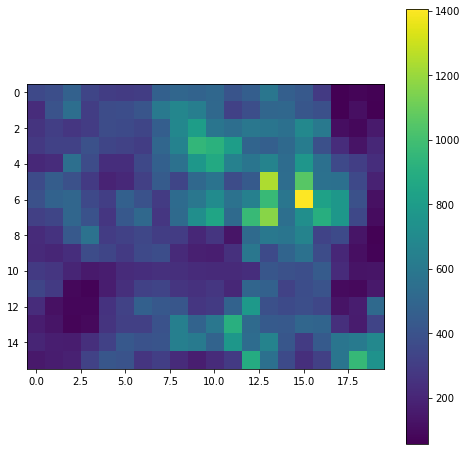

In [76]:
plt.figure(figsize = (8,8))
plt.imshow(grid_menas_sub_2d, interpolation='nearest')
plt.colorbar()
plt.show()

then we got the right cells

###  Get the data of these grids:

In [34]:
final_grids = pd.DataFrame()
for g in indeces_indv:
    g5 = full_grid.get_group(g)
    final_grids = pd.concat([final_grids, g5])

In [35]:
final_grids

,time,grid_square,internet_cdr
40568832,2013-11-01 00:00:00,4545,329.109978
40568833,2013-11-01 00:10:00,4545,322.224319
40568834,2013-11-01 00:20:00,4545,419.946349
40568835,2013-11-01 00:30:00,4545,249.132200
40568836,2013-11-01 00:40:00,4545,246.677011
...,...,...,...
54139387,2014-01-01 23:10:00,6064,324.173095
54139388,2014-01-01 23:20:00,6064,366.725893
54139389,2014-01-01 23:30:00,6064,319.365802
54139390,2014-01-01 23:40:00,6064,297.817828


## Saving to csv

In [78]:
#saving to a CSV file:
final_grids.to_csv("working_grids.csv", index = False)

In [79]:
#Saving to a numpy array:
np.save('full_millan_time_grid_.npy', grid_menas_sub_2d)